In [2]:
import numpy as np
import pandas as pd
import sys, codecs
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
import math
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from gensim.models.phrases import Phrases,Phraser
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
import ast
import os    
import glob
import datetime
import umap
import geopandas as gpd
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
from textblob import TextBlob

/opt/conda/envs/sds2021/lib/python3.9/site-packages/spglm/utils.py:367: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if resetlist is not ():


In [26]:
frozen_model = Phraser.load('phrase_6g.pkl')
ngram_model=Word2Vec.load('ngram_onten.model')

In [27]:
# 构建字典
idf=pd.read_csv('idf.csv')
SUM=pd.read_csv('tf6g.csv')
# dictionary
idf_dict={}
for count in range(idf.shape[0]):
    idf_dict.update({idf['word'].iloc[count]:idf['idf'].iloc[count]})
SUM_dict={}
for count in range(SUM.shape[0]):
    SUM_dict.update({SUM['word'].iloc[count]:SUM['sum'].iloc[count]})
all_tfidf_dict={}
for count in range(SUM.shape[0]):
    all_tfidf_dict.update({SUM['word'].iloc[count]:SUM['sum'].iloc[count]*idf['idf'].iloc[count]})

In [28]:
%%time
# 遍历一遍全局词频词汇表（虽然是十分之一的），构建一个能替换字典，在这个字典里的就是满足条件的word，可以替换
# 快了好多，用到数据库的思想
count=0
mostsim_dict={}
for w in SUM_dict.keys():
    count=count+1
    print(count,end='\r')
    tmp= ngram_model.wv.most_similar(positive=w,topn=1)
    if(tmp[0][0] in SUM_dict.keys()
       and tmp[0][1]>0.8
       and SUM_dict[tmp[0][0]]>SUM_dict[w]
#        and all_tfidf_dict[w]<50000    #暂时不用吧
       ):
        
        mostsim_dict.update({w:tmp[0][0]})

CPU times: user 20min 24s, sys: 19min 11s, total: 39min 36s
Wall time: 2min 29s


In [25]:
df=pd.DataFrame(all_tfidf_dict,index=[0]).T
sim_dict={}
for w in df[df[0]>100000].index:

    tmp= ngram_model.wv.most_similar(positive=w,topn=1)
    if(tmp[0][0] in SUM_dict.keys()
       and tmp[0][1]>0.8
       and SUM_dict[tmp[0][0]]>SUM_dict[w]
#        and all_tfidf_dict[w]<10000
       ):
        sim_dict.update({w:tmp[0][0]})
        

mian

In [41]:
# # 主要执行语句，两个函数提取关键词，生成回归输入数据
# citys=['W','WC','E','EC','N','NW','SE','SW','RM','IG','EN','HA','UB','TW','KT','SM','CR','BR','DA']
citys=['B','L','M','G','BS','S']
# ,'B','L','M','G','BS','S'
# top500=get_top500_london()
# citys=['B']
# citys=['BS','CA','M','S','SO']
# # citys=['G','L']
# for city in citys:
#     path=r'UBDC/sale_2020/'+city+'/'
#     filepath=path+'*complex*.csv'
#     for csvname in glob.glob(filepath):
#         print(csvname)
#         get_keyword_input(csvname[0:-23]+'.csv',csvname,path)
for city in citys:
    top500=get_top500(city)
    path=r'UBDC/sale_2020/'+city+'/'
    filepath=path+'*complex*.csv'
    for csvname in glob.glob(filepath):
        print('main ',csvname)
#         get_keyword_input(csvname[0:-23]+'.csv',csvname,path)
        get_dum_input(csvname[0:-23]+'.csv',top500,path)

main  UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00009clean_token_complex.csv
/ aaa -
main  UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00006clean_token_complex.csv
/ aaa -
main  UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00000clean_token_complex.csv
/ aaa -
main  UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00003clean_token_complex.csv
/ aaa -
main  UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00002clean_token_complex.csv
/ aaa -
main  UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00010clean_token_complex.csv
/ aaa -
main  UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00005clean_token_complex.csv
/ aaa -
main  UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00007clean_token_complex.csv
/ aaa -
main  UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00008clean_

In [58]:
def get_keyword_input(filename,tokenname,path):    
    # 自动化同义词检测，为csv加一列tfidf_key
    df_b_=pd.read_csv(filename)
# ###############################################
#     # arr=df_b_.token.to_numpy()
#     df_b_token=pd.read_csv(tokenname)
#     arr_token=df_b_token.des_clea.to_numpy()
#     # arr_token
#     for count in range(arr_token.shape[0]):
#         arr_token[count]=frozen_model[eval(arr_token[count])]
#     # 同义词检测 similarity   
#     replacecount=0
#     for count in range(arr_token.shape[0]):
#         print(count,' ',replacecount,end='\r')
#         delwords=[]
#         for count1 in range(len(arr_token[count])):
#             word=arr_token[count][count1]
#             if word not in ngram_model.wv :
#                 delwords.append(word)
#             else:
#                 if word in mostsim_dict.keys():
#                     arr_token[count][count1]=mostsim_dict[word]
#                     replacecount=replacecount+1
#         for  x in delwords:
#             arr_token[count].remove(x)

#     df_arr=pd.DataFrame(arr_token)
#     df_arr. 

    arr_token=pd.read_csv(path+tokenname[-28:-23]+'_token_sim.csv')['0'].to_numpy()    #'UBDC/sale_2020/B/00001_token_sim.csv'      

    vectorizer = CountVectorizer()  
    X = vectorizer.fit_transform(str(x) for x in arr_token)
    wordlist=vectorizer.get_feature_names()
    arr_word=X.toarray() #词频矩阵
    # 去重 好像是去掉countVectoer产生的乱新词
    arr_word=arr_word.T
    delindex=[]
    for count in range(len(wordlist)):
        if wordlist[count] not in ngram_model.wv or wordlist[count] not in idf_dict.keys():
            delindex.append(count)
    arr_word=np.delete(arr_word,delindex,0) #矩阵乱新词
    popnum=0
    for wordindex in delindex:  #单词索引乱新词
        wordlist.pop(wordindex-popnum)
        popnum=popnum+1
    arr_word=arr_word.T
    # 巨快无比 compute tfidf array much faster than dataframe
    for countx in range(arr_word.shape[0]): #des
        print(countx,end='\r')
        for county in range(arr_word.shape[1]): #word
            if arr_word[countx][county]!=0:
                arr_word[countx][county]=arr_word[countx][county]*idf_dict[wordlist[county]]
    # 合并 connect keyword and df
    df_b_['tfidf_key']=0
    for countx in range(arr_word.shape[0]): #des
        tmplist=[]
        for x in arr_word[countx].argsort()[-20:]:
            tmplist.append(wordlist[x])
        df_b_['tfidf_key'].iloc[countx]=tmplist
    df_b_.to_csv(filename,index=False,encoding="utf_8_sig")

In [51]:
df_b=pd.read_csv('UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00001.csv')
# arr=df_b_.token.to_numpy()
df_b_token=pd.read_csv('UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00001clean_token_complex.csv')

ngram

In [229]:
arr_token=df_b_token.des_clea.to_numpy()
# arr_token
for count in range(arr_token.shape[0]):
    arr_token[count]=frozen_model[eval(arr_token[count])]

similarity

In [ ]:
import csv
csv_reader = csv.reader(open("2020_token_uni.csv))
for line in csv_reader:
    print(line)

In [191]:
%%time
# 相似度检测替换 2.10h
replacecount=0
for count in range(arr_token.shape[0]):
    print(count,' ',replacecount,end='\r')
    delwords=[]
    for count1 in range(len(arr_token[count])):
        word=arr_token[count][count1]
        if word not in ngram_model.wv :
            delwords.append(word)
        else:
            tmp= ngram_model.wv.most_similar(positive=word,topn=1)
            SUMval=SUM['word'].values
            if (tmp[0][1]>0.8 
            and tmp[0][0] in SUMval 
            and word in SUMval  
            and SUM_dict[tmp[0][0]]>SUM_dict[word]
            and all_tfidf_dict[word]<10000):
#             and SUM[SUM['word']==tmp[0][0]]['sum'].iloc[0]>SUM[SUM['word']==word]['sum'].iloc[0] 
#             and SUM[SUM['word']==word]['sum'].iloc[0]*idf[idf['word']==word]['idf'].iloc[0]<10000):
                arr_token[count][count1]=tmp[0][0]
                replacecount=replacecount+1
    for  x in delwords:
        arr_token[count].remove(x)
                

CPU times: user 14h 36min 40s, sys: 9h 59min 57s, total: 1d 36min 38s
Wall time: 1h 32min 26s


In [35]:
# df_arr=pd.DataFrame(arr_token)
# df_arr.to_csv('UBDC/sale_2020/B/00001_token_sim.csv',index=False)

arr_token=pd.read_csv('UBDC/sale_2020/B/00001_token_sim.csv')['0'].to_numpy()

In [33]:
%%time
delindex=[2,3,4]
lista=[1,2,3,4,5,6]
# lista.pop(2)
# lista
popnum=0
for wordindex in delindex:
    lista.pop(wordindex-popnum)
    popnum=popnum+1
lista

CPU times: user 8 µs, sys: 4 µs, total: 12 µs
Wall time: 13.6 µs


[1, 2, 6]

In [36]:
vectorizer = CountVectorizer()  
X = vectorizer.fit_transform(str(x) for x in arr_token)
wordlist=vectorizer.get_feature_names()
arr_word=X.toarray() #词频矩阵

In [37]:
# 去重
arr_word=arr_word.T
delindex=[]
for count in range(len(wordlist)):
    if wordlist[count] not in ngram_model.wv or wordlist[count] not in idf_dict.keys():
        delindex.append(count)
arr_word=np.delete(arr_word,delindex,0) #矩阵去重
popnum=0
for wordindex in delindex:  #单词索引去重
    wordlist.pop(wordindex-popnum)
    popnum=popnum+1

In [40]:
len(wordlist)
arr_word.shape

(12789, 8361)

In [41]:
arr_word=arr_word.T
arr_word.shape

(8361, 12789)

In [43]:
# 巨快无比 compute tfidf array much faster than dataframe
for countx in range(arr_word.shape[0]): #des
    print(countx,end='\r')
    for county in range(arr_word.shape[1]): #word
        if arr_word[countx][county]!=0:
            arr_word[countx][county]=arr_word[countx][county]*idf_dict[wordlist[county]]

In [54]:
arr_word[countx].argsort()[-20:]

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
df_b_['tfidf_key']=0
for countx in range(arr_word.shape[0]): #des
    tmplist=[]
    for x in arr_word[countx].argsort()[-20:]:
        tmplist.append(wordlist[x])
    df_b_['tfidf_key'].iloc[countx]=tmplist
df_b_.to_csv('UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00001.csv',index=False)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


regression

In [39]:
def senti_ana(df):
    df['polarity']=0
    df['subjectivity']=0
    for count in range(df.shape[0]):
        blob = TextBlob(df.description[count])
        df['polarity'].iloc[count]= blob.sentiment[0]
        df['subjectivity'].iloc[count]= blob.sentiment[1]
    return df


def get_dum_input(filename,top500,path):
    df_b=pd.read_csv(filename)
    df_b=senti_ana(df_b)
#   sentiment analysis 

#     清理不用的列，提取出top500 keyword
    
    dropcol=['listing_id',
             'start_date',
             'price_first',
             'price_min',
             'price_max',
             'price_unique',
             'price_flag',
             'num_bed_first',
             'num_bed_min',
             'num_bed_max',
             'listing_status',
             'epc_list',
             'details_url',
             'short_description',
             'category',
             'description',
             'zdocument',
             'branch_id',
             'image_url',
             'agent_logo',
             'agent_phone',
             'agent_address',
             'agent_postcode',
             'image_caption',
             'thumbnail_url',
             'floor_plan',
             'original_image',
             ]
    
    df_b.drop(dropcol,axis=1,inplace=True)
    df_b.drop(df_b[df_b['num_bath_min']!=df_b['num_bath_max']].index,inplace= True)
    df_b.drop(df_b[df_b['num_floors_min']!=df_b['num_floors_max']].index,inplace= True)
    df_b.drop(df_b[df_b['num_reception_min']!=df_b['num_reception_max']].index,inplace= True)
    df_b.drop(['num_floors_min','num_bath_min','num_reception_min'],axis=1,inplace=True)
    df_b.drop(df_b[df_b.property_type.isnull()].index,inplace=True)
    df_b.reset_index(drop=True,inplace=True)
    df_xy=df_b[['lon','lat']]
    tmplist=['pcu','lon','lat','address','street_name','property_num','post_town','country','agent_name','bullet']
    df_b.drop(tmplist,axis=1,inplace=True)
    
    
    # 求des的哑变量：arr矩阵转df再与原来的df连接
#     top500=get_top500(city) #top500 word
    # top500=list(aa)
    arr_dum500=np.zeros((df_b.shape[0],500))
    df_b.tfidf_key= df_b.tfidf_key.apply(ast.literal_eval)
    for count in range(df_b.shape[0]):
        for count1 in range(20):
            if df_b.tfidf_key.iloc[count][count1] in top500:
                arr_dum500[count][top500.index(df_b.tfidf_key.iloc[count][count1])]=1
    df_top500=pd.DataFrame(arr_dum500)
    df_top500.columns=top500

    df_top500.index=df_top500.index.astype('int64')
    df_b_reg=pd.concat([df_b,df_top500],axis=1)
#     df_b_tfkey=df_b_reg[['tfidf_key']]  # sotre tfidf keyword
    df_b_reg.drop(['tfidf_key'],axis=1,inplace=True)
    # process date
    print(df_b_reg.end_date.iloc[1][4],'aaa','-')
    if df_b_reg.end_date.iloc[1][4]=='-':
        for count in range(df_b_reg.shape[0]):
            df_b_reg.end_date.iloc[count] = datetime.datetime.strptime(df_b_reg.end_date.iloc[count], "%Y-%m-%d")
    else:
        for count in range(df_b_reg.shape[0]):
            df_b_reg.end_date.iloc[count] = datetime.datetime.strptime(df_b_reg.end_date.iloc[count], "%Y/%m/%d")
    mindate=datetime.datetime.strptime('2019-10-1', "%Y-%m-%d")
    for count in range(df_b_reg.shape[0]):
        df_b_reg.end_date.iloc[count] = (df_b_reg.end_date.iloc[count]-mindate).days
    df_b_reg.end_date=df_b_reg.end_date.astype(int)
    # 哑变量
    df_b_reg_dum=pd.get_dummies(df_b_reg)
    df_b_reg_dum=pd.concat([df_b_reg_dum,df_xy],axis=1)
    # get the input of regression
    df_b_reg_dum.to_csv(path+filename[-9:-4]+'_diminput.csv',index=False)



In [34]:
def get_top500(city):
    key=[]
    path=r'UBDC/sale_2020/'+city+'/'
# for filename in os.listdir(path):
#     print(filename)
    filepath=path+'*complex*.csv'
#     print(filepath)
    for csvname in glob.glob(filepath):
#         print(csvname)
        keylist=pd.read_csv(csvname[0:-23]+'.csv').tfidf_key.to_list()
        for li in keylist:
            key.append(li)
    vectorizer = CountVectorizer()  
    X = vectorizer.fit_transform(k for k in key)
    word=vectorizer.get_feature_names()
#     tfidfX=X.toarray()
#     tfsum=[]
#     for x in range(tfidfX.shape[1]):
#         tfsum.append(tfidfX[:,x].sum())
    df_keynum=pd.DataFrame(np.array(X.sum(axis=0))[0],index=word)
    top500=df_keynum.sort_values(by=0,ascending=False)[0:500].index
    return list(top500)
    

In [35]:
def get_top500_london():
    london_citys=['W','WC','E','EC','N','NW','SE','SW','RM','IG','EN','HA','UB','TW','KT','SM','CR','BR','DA']
    key=[]
    for city in london_citys:
        path=r'UBDC/sale_2020/'+city+'/'
    # for filename in os.listdir(path):
    #     print(filename)
        filepath=path+'*complex*.csv'
    #     print(filepath)
        for csvname in glob.glob(filepath):
    #         print(csvname)
            keylist=pd.read_csv(csvname[0:-23]+'.csv').tfidf_key.to_list()
            for li in keylist:
                key.append(li)
    vectorizer = CountVectorizer()  
    X = vectorizer.fit_transform(k for k in key)
    word=vectorizer.get_feature_names()
#     tfidfX=X.toarray()
#     tfsum=[]
#     for x in range(tfidfX.shape[1]):
#         tfsum.append(tfidfX[:,x].sum())
    df_keynum=pd.DataFrame(np.array(X.sum(axis=0))[0],index=word)
    top500=df_keynum.sort_values(by=0,ascending=False)[0:500].index
    return list(top500)

connect input data

In [89]:
lad=0
cou=0
list_county=[]
for w in df_input.columns:
    if w[0:4]=='lad2':
        lad=lad+1
    if w[0:6]=='county':
        cou=cou+1
        
        
        
        
# cou 7,25
df_input.columns.tolist()

['county_London',
 'county_Bristol',
 'county_Hertfordshire',
 'county_Surrey',
 'county_South Yorkshire',
 'county_Essex',
 'county_Kent']

In [4]:
df_input.columns.tolist()

['end_date',
 'price_last',
 'num_bed_last',
 'num_floors_max',
 'num_bath_max',
 'num_reception_max',
 'road',
 'station',
 'floor',
 'glaze',
 'park',
 'reception',
 'underground',
 'radiator',
 'london',
 'garden',
 'modern',
 'family',
 'private',
 'communal',
 'offer',
 'walk',
 'tube',
 'refurbish',
 'balcony',
 'bright',
 'situated',
 'school',
 'house',
 'west',
 'stunning',
 'victorian',
 'development',
 'tiled',
 'moment',
 'space',
 'extend',
 'lovely',
 'separate',
 'residential',
 'shop',
 'ideal',
 'fit',
 'excellent',
 'link',
 'terrace',
 'overground',
 'chain',
 'boast',
 'potential',
 'plan',
 'wood',
 'south',
 'amenity',
 'lease',
 'fantastic',
 'carpet',
 'pleased',
 'lounge',
 'garage',
 'easy',
 'sale',
 'green',
 'transport',
 'dining',
 'kitchen',
 'bathroom',
 'hill',
 'cafe',
 'access',
 'concierge',
 'bus_route',
 'heart',
 'benefit',
 'share_freehold',
 'conversion',
 'laminate',
 'prospective',
 'quiet',
 'spacious',
 'building',
 'market',
 'buyer',
 'pop

In [2]:
# 连接input csv
citys=['W','WC','E','EC','N','NW','SE','SW','RM','IG','EN','HA','UB','TW','KT','SM','CR','BR','DA']
# citys=['M']
firstflag=0
for city in citys:
    path=r'UBDC/sale_2020/'+city+'/'
    filepath=path+'*dim*.csv'
    #     print(filepath)
    for csvname in glob.glob(filepath):
        print(csvname)
        if firstflag==0:
            df_input=pd.read_csv(csvname)
            firstflag=1
        else:
            df_input=df_input.append(pd.read_csv(csvname),ignore_index=True)
df_input=df_input.fillna(0)
df_input_store=df_input[['polarity','subjectivity','lon','lat']]
df_input.drop(['lon','lat','Unnamed: 0','Unnamed: 0.1','bed_flag','polarity','subjectivity'],axis=1,inplace=True)
list_county=[w for w in df_input.columns if w[0:6]=='county']
df_input.drop(list_county,axis=1,inplace=True)
df_input=df_input.astype(int)
df_input=pd.concat([df_input,df_input_store],axis=1)
df_input.drop(df_input[df_input['price_last']==0].index,axis=0,inplace=True)
df_input.reset_index(drop=True,inplace=True)
# df_input_store=df_input[['E0','E1','E2','E3','E4','E5','E6','E7','E8','E9','lon','lat']]
# df_input.drop(['E0','E1','E2','E3','E4','E5','E6','E7','E8','E9','lon','lat','Unnamed: 0','Unnamed: 0.1'],axis=1,inplace=True)

UBDC/sale_2020/W/00006_diminput.csv
UBDC/sale_2020/W/00001_diminput.csv
UBDC/sale_2020/W/00000_diminput.csv
UBDC/sale_2020/W/00005_diminput.csv
UBDC/sale_2020/W/00004_diminput.csv
UBDC/sale_2020/W/00002_diminput.csv
UBDC/sale_2020/W/00003_diminput.csv
UBDC/sale_2020/WC/00000_diminput.csv
UBDC/sale_2020/E/00006_diminput.csv
UBDC/sale_2020/E/00001_diminput.csv
UBDC/sale_2020/E/00000_diminput.csv
UBDC/sale_2020/E/00005_diminput.csv
UBDC/sale_2020/E/00004_diminput.csv
UBDC/sale_2020/E/00002_diminput.csv
UBDC/sale_2020/E/00003_diminput.csv
UBDC/sale_2020/EC/00000_diminput.csv
UBDC/sale_2020/N/00001_diminput.csv
UBDC/sale_2020/N/00000_diminput.csv
UBDC/sale_2020/N/00005_diminput.csv
UBDC/sale_2020/N/00004_diminput.csv
UBDC/sale_2020/N/00002_diminput.csv
UBDC/sale_2020/N/00003_diminput.csv
UBDC/sale_2020/NW/00001_diminput.csv
UBDC/sale_2020/NW/00000_diminput.csv
UBDC/sale_2020/NW/00004_diminput.csv
UBDC/sale_2020/NW/00002_diminput.csv
UBDC/sale_2020/NW/00003_diminput.csv
UBDC/sale_2020/SE/000

In [3]:
borough=gpd.read_file('London_Boroughs.gpkg')
gdf_input=gpd.GeoDataFrame(df_input[['lon','lat']],geometry=gpd.points_from_xy(df_input.lon, df_input.lat, crs='epsg:4326'))
gdf_input=gdf_input.to_crs("epsg:27700")
gdf_input=gpd.sjoin(gdf_input,borough[['geometry']], how="inner", op='intersects').reset_index()
london_index=gdf_input['index']
df_input=df_input.iloc[london_index]
num0col=pd.DataFrame(df_input.sum()) #remove sum=0 columns
col=num0col[num0col[0]==0].index
df_input.drop(col,axis=1,inplace=True)
df_input.reset_index(drop=True,inplace=True)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [13]:
df_input.to_csv('london_dim.csv',index=False)

In [14]:
df_input[['lon','lat']].to_csv('london_dim_lonlat.csv',index=False)

In [4]:
df_input=pd.read_csv('london_dim.csv')
df_input=df_input.rename(columns={'end_date':'date_since_2019','num_bed_last':'num_bed',
'num_floors_max':'num_floors',
 'num_bath_max':'num_bath',
 'num_reception_max':'num_reception',
'polarity':"sentiment_polarity",
 'subjectivity':'sentiment_subjectivity'})
useless_var=['situated', 'stunning', 'local', 'tap', 'finish', 'mixer', 'view',
       'internal', 'unique', 'guide', 'precise_advise', 'mention_agree',
       'regard', 'heathrow_airport', 'excess', 'purchaser', 'national',
       'vinyl', 'marble', 'property_type_Maisonette',
       'property_type_Restaurant/cafe', 'lad20nm_Epping Forest',
       'property_type_Office', 'property_type_Industrial',
       'lad20nm_Hertsmere', 'lad20nm_Three Rivers',
       'lad20nm_Buckinghamshire']
df_input.drop(useless_var,axis=1,inplace=True)
notext_index=df_input[df_input.iloc[:,5:486].T.sum()==0].index #去掉单词列全为零的行
df_input.drop(notext_index,axis=0,inplace=True)

In [2]:
df_input.to_csv('london_dim1.csv',index=False) #去掉lasso的无用变量
df_input[['lon','lat']].to_csv('london_dim_lonlat1.csv',index=False)

NameError: name 'df_input' is not defined

In [3]:
df_input=pd.read_csv('london_dim1.csv')

In [11]:
# df_input.drop(df_input.columns[6:487],axis=1,inplace=True)
df_input.columns.tolist()[500]


'property_type_Semi-detached house'

test set

In [12]:
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:487]
train_x, test_x, train_y, test_y = train_test_split(df_input.drop(['price_last'], axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x[['lon','lat']]
test_x_g=test_x[['lon','lat']]
train_x.drop(['lon','lat'],axis=1,inplace=True)
test_x.drop(['lon','lat'],axis=1,inplace=True)
train_x.reset_index(inplace=True,drop=True)
test_x.reset_index(inplace=True,drop=True)
train_y.reset_index(inplace=True,drop=True)
test_y.reset_index(inplace=True,drop=True)
# train_x

In [24]:
# notext+sen
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:487]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last','sentiment_polarity','sentiment_subjectivity']+text_col, axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

In [28]:
# nosen
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:487]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last','sentiment_polarity','sentiment_subjectivity'], axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

In [30]:
# notext
# train set and test set
random_state_split = 8
# position_col=[x for x in df_input if x[0:4]=='lad2']
text_col=df_input.columns.tolist()[6:506-487]
train_x_notext, test_x_notext, train_y_notext, test_y_notext = train_test_split(df_input.drop(['price_last']+text_col, axis = 1), df_input.price_last, random_state=random_state_split)
train_x_g=train_x_notext[['lon','lat']]
test_x_g=test_x_notext[['lon','lat']]
train_x_notext.drop(['lon','lat'],axis=1,inplace=True)
test_x_notext.drop(['lon','lat'],axis=1,inplace=True)
train_x_notext.reset_index(inplace=True,drop=True)
test_x_notext.reset_index(inplace=True,drop=True)
train_y_notext.reset_index(inplace=True,drop=True)
test_y_notext.reset_index(inplace=True,drop=True)

lasso

In [18]:
%%time
lasso_model = Lasso( normalize=True)
lasso_model.fit(X=train_x, y=train_y)

CPU times: user 26min 13s, sys: 1h 2min 46s, total: 1h 28min 59s
Wall time: 5min 39s


Lasso(normalize=True)

In [19]:
# london  cor text
# 0.4100302530713664
# 0.42331381360981324
# 0.3624131471338077 nocor
# 0.3747405689839195
# 0.36121667124471024 notext
# 0.37413963501097536
lasso_model.score(X=train_x, y=train_y)

0.41043196251443037

In [20]:
lasso_model.score(X=test_x, y=test_y)

0.4237690548270563

In [49]:
# bh
lasso_model.score(X=train_x, y=train_y)

0.631219776217842

In [50]:
lasso_model.score(X=test_x, y=test_y)

0.6561480959036057

In [4]:
%%time
from sklearn.linear_model import LassoCV
alphas = 10**np.linspace(- 3, 3, 100) 
lasso_cv = LassoCV(alphas = alphas, normalize= True, cv = 20, max_iter= 500000).fit(train_x, train_y)

CPU times: user 24min 25s, sys: 1h 11min 18s, total: 1h 35min 43s
Wall time: 11min 36s


In [14]:
# london
# best_alpha=lasso_cv.alpha_
best_alpha=0.40370172585965536
lasso_model = Lasso(max_iter=10e7, normalize=True, alpha = best_alpha)
lasso_model.fit(X=train_x, y=train_y)
print(lasso_model.score(test_x, test_y))

0.4162933657848569


In [6]:
best_alpha

0.40370172585965536

In [17]:
lasso_model.score(X=test_x, y=test_y)

0.4233697471356478

In [15]:
pd.set_option('display.max_rows', 200)
df_coef_lasso = pd.DataFrame({"var": train_x.columns.values, "coef":lasso_model.coef_})
useless_var=df_coef_lasso[df_coef_lasso.coef==0]['var'].values
useless_var

array(['situated', 'stunning', 'local', 'tap', 'finish', 'mixer', 'view',
       'internal', 'unique', 'guide', 'precise_advise', 'mention_agree',
       'regard', 'heathrow_airport', 'excess', 'purchaser', 'national',
       'vinyl', 'marble', 'property_type_Maisonette',
       'property_type_Restaurant/cafe', 'lad20nm_Epping Forest',
       'property_type_Office', 'property_type_Industrial',
       'lad20nm_Hertsmere', 'lad20nm_Three Rivers',
       'lad20nm_Buckinghamshire'], dtype=object)

In [5]:
useless_var=['situated', 'stunning', 'local', 'tap', 'finish', 'mixer', 'view',
       'internal', 'unique', 'guide', 'precise_advise', 'mention_agree',
       'regard', 'heathrow_airport', 'excess', 'purchaser', 'national',
       'vinyl', 'marble', 'property_type_Maisonette',
       'property_type_Restaurant/cafe', 'lad20nm_Epping Forest',
       'property_type_Office', 'property_type_Industrial',
       'lad20nm_Hertsmere', 'lad20nm_Three Rivers',
       'lad20nm_Buckinghamshire']
train_x.drop(useless_var,axis=1,inplace=True)
test_x.drop(useless_var,axis=1,inplace=True)

In [19]:
%%time
lasso_model = Lasso( normalize=True)
lasso_model.fit(X=train_x_notext, y=train_y_notext)
print(lasso_model.score(X=train_x_notext, y=train_y_notext),'\n',lasso_model.score(X=test_x_notext, y=test_y_notext))

0.4119730009455824 
 0.4153123311858663
CPU times: user 17min 38s, sys: 37min 21s, total: 54min 59s
Wall time: 3min 28s


In [ ]:
# 伯明翰
# 0.6323571460371419  train
# 0.30538555088334157 alpha
# 0.6566403249395409 text
伦敦
0.5367307713496702
4.9770235643321135
0.5299216387999275

regression tree

In [12]:
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=8)
# if you don't remember the meaning of random_state, check out the lastest clustering workshop on Moodle
reg_tree.fit(train_x, train_y)
print("R2 on the training data:")
print(reg_tree.score(X=train_x, y=train_y))
print("R2 on the testing data:")
print(reg_tree.score(X=test_x, y=test_y))
from sklearn.metrics import mean_squared_error
print("RMSE on the training data:")
print(mean_squared_error(train_y, reg_tree.predict(train_x), squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(test_y, reg_tree.predict(test_x), squared=False))

R2 on the training data:
0.9998316988861337
R2 on the testing data:
0.8354804026739485
RMSE on the training data:
14269.681939051034
RMSE on the testing data:
447086.70777530357


                                Importance
Feature                                   
num_reception                     3.116961
num_bed                           0.556933
num_bath                          0.530489
lad20nm_Westminster               0.466144
lad20nm_Kensington and Chelsea    0.358482
...                                    ...
versatile                        -0.001286
benefit                          -0.001463
wonderfully                      -0.001553
bus_route                        -0.001659
fill                             -0.002212

[583 rows x 1 columns]


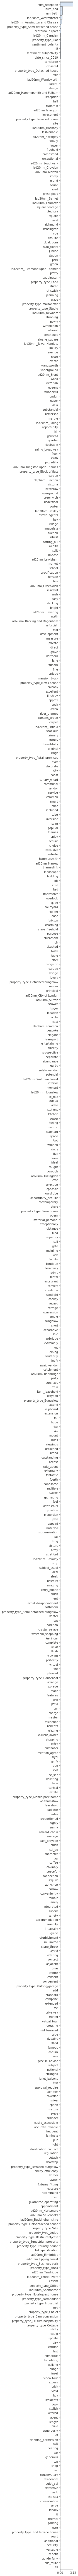

In [6]:
import rfpimp
imp = rfpimp.importances(reg_tree, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

In [25]:
# 没文本变量的
from sklearn.tree import DecisionTreeRegressor
reg_tree = DecisionTreeRegressor(random_state=8)
# if you don't remember the meaning of random_state, check out the lastest clustering workshop on Moodle
reg_tree.fit(train_x_notext, train_y_notext)
print("R2 on the training data:")
print(reg_tree.score(X=train_x_notext, y=train_y_notext))
print("R2 on the testing data:")
print(reg_tree.score(X=test_x_notext, y=test_y_notext))
from sklearn.metrics import mean_squared_error
# print("RMSE on the training data:")
# print(mean_squared_error(train_y, reg_tree.predict(train_x), squared=False))
# print("RMSE on the testing data:")
# print(mean_squared_error(test_y, reg_tree.predict(test_x), squared=False))

R2 on the training data:
0.959327644540924
R2 on the testing data:
0.8225751027495057


random forest

In [32]:
%%time
from sklearn.ensemble import RandomForestRegressor
randomState_rf = 8
rf = RandomForestRegressor(n_estimators=50, random_state=randomState_rf,n_jobs=-1)
rf.fit(train_x,train_y)
print("R2 on the training data:")
print(rf.score(train_x,train_y))
print("R2 on the testing data:")
print(rf.score(test_x,test_y))

R2 on the training data:
0.9799059781087105
R2 on the testing data:
0.8860245727639057
CPU times: user 2h 37min 17s, sys: 23 s, total: 2h 37min 40s
Wall time: 10min 42s


In [ ]:
R2 on the training data:
0.9787889576277278
R2 on the testing data:
0.9038636703732689
CPU times: user 2h 34min 46s, sys: 23.3 s, total: 2h 35min 9s
Wall time: 10min 25s

In [31]:
%%time
# 没文本变量的

from sklearn.ensemble import RandomForestRegressor
randomState_rf = 8
rf = RandomForestRegressor(n_estimators=50, random_state=randomState_rf,n_jobs=-1)
rf.fit(train_x_notext,train_y_notext)
print("R2 on the training data:")
print(rf.score(train_x_notext,train_y_notext))
print("R2 on the testing data:")
print(rf.score(test_x_notext,test_y_notext))

R2 on the training data:
0.97945361268475
R2 on the testing data:
0.886605609536265
CPU times: user 2h 27min 28s, sys: 8.6 s, total: 2h 27min 37s
Wall time: 9min 50s


In [34]:
pip install rfpimp

  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10668 sha256=e7e7ef3e8cdf19b8b4424c16fc820e25cac741169852968b0c1036aaa4b43ef0
  Stored in directory: /home/jovyan/.cache/pip/wheels/d9/f2/53/6d8c73011f73fc347598d683ff8b2343605ad43474ae083816
Successfully built rfpimp
Note: you may need to restart the kernel to use updated packages.


                                Importance
Feature                                   
num_reception                     1.380982
num_bath                          0.626913
lad20nm_Westminster               0.364691
num_bed                           0.280683
lad20nm_Kensington and Chelsea    0.214279
...                                    ...
video                            -0.000458
development                      -0.000656
family                           -0.000677
storey                           -0.001551
arranged                         -0.002459

[556 rows x 1 columns]


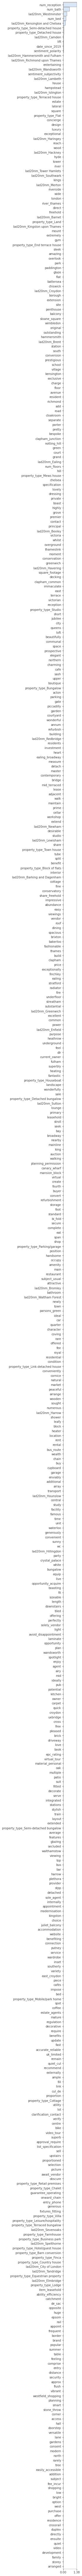

In [35]:
import rfpimp
imp = rfpimp.importances(rf, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()
# cafes luxury ideal rare

In [38]:
imp[0:50].to_csv('ld_sig50.csv')

In [ ]:
%%time
# cross va
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
# X_train_val = pd.concat([train_x])
# y_train_val = pd.concat([train_y])
# values of n_estimators
parameters = {'n_estimators':[10,20,30,40,50]}
rf = RandomForestRegressor(n_jobs=-1)

# cv=5 by default, which means 5-fold cross-validation
clf = model_selection.GridSearchCV(rf, parameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

red dim for gwr

In [152]:
# train_x.to_csv('train_x.csv',index=False)
# train_y.to_csv('train_y.csv',index=False)
# train_x_g.to_csv('train_x_g.csv',index=False)
train_x=pd.read_csv('train_x.csv')[0:50000]
train_y=pd.read_csv('train_y.csv')[0:50000]
train_x_g=pd.read_csv('train_x_g.csv')[0:50000]

In [226]:
gdf_price=pd.concat([train_y,train_x_g],axis=1)

In [227]:
gdf_price=gpd.GeoDataFrame(gdf_price,geometry=gpd.points_from_xy(gdf_price.lon, gdf_price.lat, crs='epsg:4326'))
gdf_price=gdf_price.to_crs("epsg:27700")

In [228]:
gdf_price

,price_last,lon,lat,geometry
0,495000,-0.154402,51.406284,POINT (528466.040 169088.812)
1,625000,-0.075536,51.545210,POINT (533545.017 184678.752)
2,1400000,-0.152978,51.462315,POINT (528407.996 175322.095)
3,325000,-0.073497,51.532707,POINT (533723.011 183292.100)
4,650000,-0.418379,51.513880,POINT (509848.025 180624.944)
...,...,...,...,...
29995,530000,-0.059106,51.504944,POINT (534803.004 180231.163)
29996,280000,0.035955,51.532420,POINT (541315.023 183465.761)
29997,795000,0.006093,51.487130,POINT (539381.979 178372.231)
29998,395000,-0.332710,51.580692,POINT (515623.038 188186.833)


In [153]:
df_toUMAP=train_x.drop(['date_since_2019',
 'num_bed',
#  'num_floors',
 'num_bath',
 'num_reception','sentiment_polarity',
 'sentiment_subjectivity'],axis=1)
#  ,'luxury' ,'ideal', 'rare'
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.01,
    n_components=5,
    random_state=8)

arr_UMAP=reducer.fit_transform(df_toUMAP)

df_x_10=pd.DataFrame(arr_UMAP,columns= ['E'+str(x) for x in np.arange(0,5)])
train_x=pd.concat([train_x[['date_since_2019',
 'num_bed',
#  'num_floors',
 'num_bath',
 'num_reception','sentiment_polarity',
 'sentiment_subjectivity']],df_x_10],axis=1) 
# df.to_csv(file,encoding="utf_8_sig",index=False)

In [154]:
train_x.to_csv('train_x50000_lond.csv',index=False)
train_y.to_csv('train_y50000_lond.csv',index=False)
train_x_g.to_csv('train_x_g50000_lond.csv',index=False)

In [3]:
train_x=pd.read_csv('train_x50000_lond.csv')
train_y=pd.read_csv('train_y50000_lond.csv')
train_x_g=pd.read_csv('train_x_g50000_lond.csv')
# train_x=train_x.drop('cafés',axis=1)

In [4]:
train_x

,date_since_2019,num_bed,num_bath,num_reception,sentiment_polarity,sentiment_subjectivity,E0,E1,E2,E3,E4
0,547,3,1,1,0.176333,0.492462,7.857202,6.338008,3.299328,4.261598,5.695811
1,546,2,1,1,0.152220,0.470209,9.844131,5.553416,4.120771,1.557802,1.984736
2,412,5,2,2,0.134636,0.532097,8.455034,6.423052,3.714390,4.440700,5.337656
3,444,1,1,1,-0.009583,0.345694,9.921549,5.537663,3.999540,1.454446,1.892441
4,337,6,2,2,0.166429,0.377857,8.093443,4.499049,3.814688,1.831503,5.614601
...,...,...,...,...,...,...,...,...,...,...,...
49995,524,8,3,2,0.341390,0.508652,8.396036,5.790758,4.017933,4.308973,5.471036
49996,97,7,5,4,0.395253,0.603838,8.742443,5.571414,3.026354,2.182123,5.546758
49997,492,1,1,1,0.140000,0.345000,10.239676,8.017057,4.331475,2.880720,3.242164
49998,295,2,2,1,0.209587,0.561218,9.228417,6.058389,4.710180,1.118273,2.674879


gwr

In [111]:
%%time
def get_red4(train_x):  
    reduce_var=np.hstack((train_x.columns[3],train_x.columns[506:-12])).tolist()
    df_toUMAP=train_x[reduce_var]
    df_toUMAP

    reducer = umap.UMAP(
        n_neighbors=25,
        min_dist=0.01,
        n_components=4,
        random_state=8)

    arr_UMAP=reducer.fit_transform(df_toUMAP)
    df_red4=pd.DataFrame(arr_UMAP,columns= ['E'+str(x) for x in np.arange(10,14)])
    tain_x=pd.concat([train_x,df_red4],axis=1)
    return tain_x

train_x=get_red4(train_x)
test_x=get_red4(test_x)

# for file in fileorder:
#     df=pd.read_csv(file)
#     df_UMAP=pd.DataFrame(arr_UMAP[0:df.shape[0]],columns= ['E'+str(x) for x in np.arange(0,10)])
#     df=pd.concat([df,df_UMAP],axis=1) 
#     df.to_csv(file,encoding="utf_8_sig")
#     arr_UMAP= arr_UMAP[df.shape[0]:]

CPU times: user 47min 17s, sys: 15min 37s, total: 1h 2min 55s
Wall time: 11min 27s


In [147]:
gwr_var=np.hstack((train_x.columns[0:2],train_x.columns[4:7],train_x.columns[-16:-6],train_x.columns[-4:])).tolist()
# gwr_var=np.hstack((train_x.columns[0:2],train_x.columns[3:9])).tolist()
gwr_var
dropname=[]
for w in gwr_var:
    if w[0:6]=='county' or w[0:6]=='lad20n':
        dropname.append(w)
for x in dropname:
    gwr_var.remove(x)
gwr_var

['end_date',
 'num_bed_last',
 'num_bath_max',
 'num_reception_max',
 'apartment',
 'E0',
 'E1',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9',
 'E10',
 'E11',
 'E12',
 'E13']

In [254]:
# gwr input
# train_x=pd.read_csv('train_x.csv')[0:30000]
# train_y=pd.read_csv('train_y.csv')[0:30000]
# train_x_g=pd.read_csv('train_x_g.csv')[0:30000]
train_cor=list(zip(train_x_g['lon'],train_x_g['lat']))
# test_cor=list(zip(test_x['lon'],test_x['lat']))
train_x_g1=train_x.values
# test_x_g=test_x[gwr_var].values
train_y_g1 =train_y.values.reshape((-1,1))
# test_y_g =test_y.values.reshape((-1,1))
# train_cor1=train_cor[0:5000]
# train_y_g1=train_y_g[0:5000]
# train_x_g1=train_x_g[0:5000]

In [130]:
# for x in range(train_x_g1.shape[0]):
for x in range(train_x_g.shape[0]):
#     if train_x_g1[x][6]==1:
    train_x_g1[x][6]= train_x_g1[x][6]+1234


In [256]:
%%time
# london 20000 116
gwr_selector = Sel_BW(train_cor, train_y_g1, train_x_g1)
gwr_bw = gwr_selector.search()
print('1')
gwr_results = GWR(train_cor, train_y_g1, train_x_g1,gwr_bw).fit()

1
CPU times: user 11h 41min 27s, sys: 1d 2h 2min 56s, total: 1d 13h 44min 24s
Wall time: 2h 21min 42s


In [18]:
del df_input

In [263]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               20000
Number of covariates:                                                    17

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       15724153444588864.000
Log-likelihood:                                                 -302283.639
AIC:                                                             604601.277
AICc:                                                            604603.312
BIC:                                                           15724153444390962.000
R2:                                                                   0.286
Adj. R2:                                                              0.285

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ----------

In [143]:
? store
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                               20000
Number of covariates:                                                    19

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                       28710865424204036.000
Log-likelihood:                                                 -308304.415
AIC:                                                             616646.831
AICc:                                                            616648.873
BIC:                                                           28710865424006156.000
R2:                                                                   0.356
Adj. R2:                                                              0.356

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ----------

In [257]:
# 回归参数
var_names=['sentiment_polarity','sentiment_subjectivity']
gwr_coefficent=pd.DataFrame(gwr_results.params[:,4:6],columns=var_names)
# 回归参数显著性
# gwr_flter_t=pd.DataFrame(gwr_results.filter_tvals())
# 将点数据回归结果放到面上展示
# 主要是由于两个文件中的记录数不同，矢量面中的记录比csv中多几条，因此需要将没有参加gwr的区域去掉

georgia_data_geo=gpd.GeoDataFrame(gwr_coefficent,geometry=gpd.points_from_xy(train_x_g[0:50000].lon, train_x_g[0:50000].lat, crs='epsg:4326'))

# 将回归参数与面数据结合
# georgia_shp_geo=gp.sjoin(georgia_shp,georgia_data_geo, how="inner", op='intersects').reset_index()

In [258]:
georgia_data_geo=georgia_data_geo.to_crs("epsg:27700")

In [259]:
gwr_flter_t=pd.DataFrame(gwr_results.filter_tvals())
gwr_flter_t[gwr_flter_t[4]!=0]
georgia_data_geo_fil=georgia_data_geo.iloc[gwr_flter_t[gwr_flter_t[4]!=0].index.tolist()]

In [260]:
georgia_data_geo_fil.head()
georgia_data_geo_fil['lon']=train_x_g[0:50000].lon
georgia_data_geo_fil['lat']=train_x_g[0:50000].lat

/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [261]:
georgia_data_geo_fil.shape

(2075, 5)

In [171]:
# georgia_shp_geo=gpd.sjoin(georgia_data_geo[['cof_apartment','geometry']],gdf[gdf['TCITY15NM']=='London'], how="inner", op='intersects').reset_index()

In [262]:
georgia_data_geo_fil.to_csv('london_gwr_pra_fil.csv')

In [171]:

georgia_data_geo=georgia_data_geo_fil



# georgia_data_geo=pd.read_csv('london_gwr_pra.csv')

# georgia_data_geo = gpd.GeoDataFrame(georgia_data_geo, 
#       geometry=gpd.points_from_xy(georgia_data_geo['lon'], georgia_data_geo['lat'], crs='epsg:4326'))
# georgia_data_geo=georgia_data_geo.to_crs("epsg:27700")

In [24]:
borough=gpd.read_file('London_Boroughs.gpkg')
b=gpd.read_file('shapefile/neighborhoodarea.zip')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [250]:
msoas

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,E02000001,City of London 001,City of London 001,532384,181355,-0.093490,51.51561,2.906361e+06,8936.818478,"POLYGON ((532135.138 182198.131, 532158.250 18..."
1,2,E02000002,Barking and Dagenham 001,Barking and Dagenham 001,548267,189685,0.138756,51.58652,2.166163e+06,8150.405928,"POLYGON ((548881.563 190845.265, 548881.125 19..."
2,3,E02000003,Barking and Dagenham 002,Barking and Dagenham 002,548259,188520,0.138149,51.57605,2.143568e+06,9118.196243,"POLYGON ((549102.438 189324.625, 548954.517 18..."
3,4,E02000004,Barking and Dagenham 003,Barking and Dagenham 003,551004,186412,0.176828,51.55638,2.491467e+06,8206.551627,"POLYGON ((551550.056 187364.705, 551478.000 18..."
4,5,E02000005,Barking and Dagenham 004,Barking and Dagenham 004,548733,186824,0.144267,51.56069,1.186053e+06,6949.688798,"POLYGON ((549099.634 187656.076, 549161.375 18..."
...,...,...,...,...,...,...,...,...,...,...,...
7196,7197,W02000419,Denbighshire 017,Sir Ddinbych 017,302419,380863,-3.466200,53.31569,2.706356e+06,9286.321706,"POLYGON ((302972.663 381406.090, 303008.064 38..."
7197,7198,W02000420,Wrexham 020,Wrecsam 020,336850,353606,-2.944070,53.07594,7.918321e+07,68550.337005,"POLYGON ((335857.094 359909.500, 335987.000 35..."
7198,7199,W02000421,Ceredigion 011,Ceredigion 011,271405,266660,-3.886550,52.28300,7.694416e+08,186339.966460,"POLYGON ((281652.906 291392.187, 281772.021 29..."
7199,7200,W02000422,Cardiff 048,Caerdydd 048,319643,174132,-3.158050,51.46043,6.518026e+06,20928.073674,"MULTIPOLYGON (((322311.497 164638.802, 322288...."


In [20]:
from shapely import geometry
cq = gpd.GeoSeries([geometry.Point(-0.088724, 51.38874)],
                         crs='EPSG:4326',  # 指定坐标系为WGS 1984
                         index=['one'],  # 相关的索引
                         )
cq=cq.to_crs("epsg:27700")

In [209]:
msoas = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Middle_Layer_Super_Output_Areas__December_2011__EW_BGC_V2-shp.zip?raw=true')
gdf = gpd.read_file('shapefile/Major_Towns_and_Cities_(December_2015)_Boundaries_V2.geojson')
ldn=gpd.read_file('London_Boroughs.gpkg')
ldn=ldn.to_crs("epsg:27700")
ldn['geometry'] = ldn['geometry'].buffer(500)
ldn = ldn.set_geometry('geometry')
ldn_msoas = gpd.sjoin(msoas, ldn,op='within')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [250]:
ldn_msoas.drop(['index_right','objectid','gss_code','hectares','nonld_area','ons_inner','sub_2011'],axis=1,inplace=True)

In [251]:
ldn_msoas_join=gpd.sjoin(ldn_msoas,georgia_data_geo)

In [252]:
msoagrdf = ldn_msoas_join.groupby('MSOA11NM').agg({'sentiment_polarity':['mean'],'sentiment_subjectivity':['mean']}).reset_index()

In [253]:
msoagrdf.columns=['MSOA11NM','sentiment_polarity_mean','sentiment_subjectivity_mean']

In [254]:
ldn_msoas_mean=pd.merge(ldn_msoas,msoagrdf,on='MSOA11NM')

In [255]:
ldn_msoas_mean.head(1)

,OBJECTID,MSOA11CD,MSOA11NM,MSOA11NMW,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,name,sentiment_polarity_mean,sentiment_subjectivity_mean
0,1,E02000001,City of London 001,City of London 001,532384,181355,-0.09349,51.51561,2.906361e+06,8936.818478,"POLYGON ((532135.138 182198.131, 532158.250 18...",City of London,288.322952,1492.730088


/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


<AxesSubplot:>

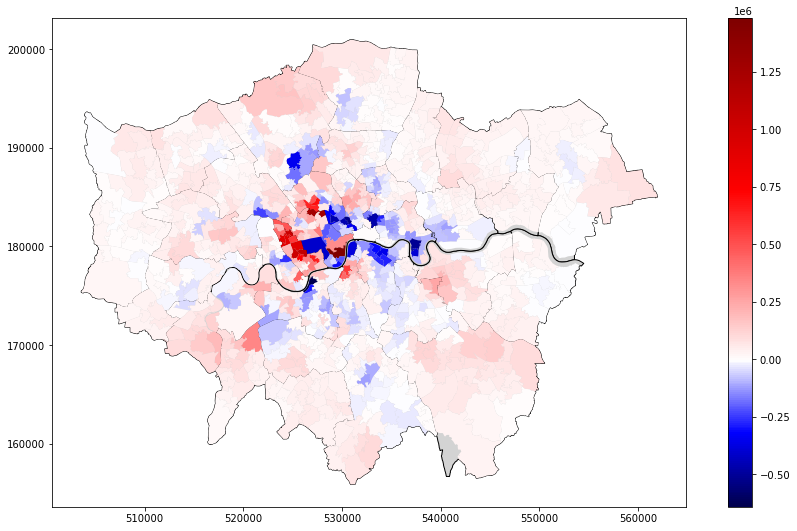

In [214]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

f,ax = plt.subplots(figsize=(15,9))
cmap = plt.cm.seismic

vmin=georgia_data_geo.sentiment_polarity.min()
vmax=georgia_data_geo.sentiment_polarity.max()
vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=0.999- vmax1/(vmax1 + abs(vmin1)))
# sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
borough.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black')
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
# georgia_data_geo.plot( column='sentiment_polarity',marker='*', markersize=1,cmap=cmap, 
#          legend=True, ax=ax)
ldn_msoas_mean.plot( column='sentiment_polarity_mean' ,cmap=cmap, 
         legend=True, ax=ax)
# georgia_data_geo.plot( column='sentiment_subjectivity',marker='*', markersize=1,cmap='viridis', 
#          legend=True, ax=ax)
# cq.plot(markersize=100, ax=ax)

# water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
# green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
# gdf.plot(column='price', scheme='Quantiles', k=5, 
#          cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
# boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

In [173]:
# c1=georgia_data_geo[georgia_data_geo['sentiment_polarity']>500000]
# c2=georgia_data_geo[georgia_data_geo['sentiment_polarity']<-500000]
# df_clu=pd.concat([c1,c2]).reset_index(drop=True)
df_clu=georgia_data_geo

cluster

In [263]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
rs = RobustScaler(quantile_range=(10.0, 90.0))
raw = df_clu[['sentiment_polarity','lon','lat','sentiment_subjectivity']].copy()
normed = raw.copy()
for c in raw.columns.values:
    normed[c] = rs.fit_transform(raw[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()
from sklearn.cluster import KMeans, DBSCAN
minPts = 5 # we set minPts as normed.shape[1] + 1 
epsilon = 0.2
dbsc = DBSCAN(eps=epsilon, min_samples=minPts)
dbsc.fit(normed)
cluster_nm = dbsc.labels_
df_clu['clu']=cluster_nm

The range of sentiment_polarity is [-0.9789269244752192, 1.0756943811720074]
The range of lon is [-1.3974776578330312, 2.0804622174047696]
The range of lat is [-1.3494974896725065, 1.3627237868727475]
The range of sentiment_subjectivity is [-2.715278748943474, 1.2427093477537126]


/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [175]:
georgia_data_geo_clu=pd.merge(georgia_data_geo,df_clu[['Unnamed: 0','clu']],how='left',on='Unnamed: 0')
georgia_data_geo_clu.fillna(-1,inplace=True)
georgia_data_geo_clu = gpd.GeoDataFrame(georgia_data_geo_clu, 
      geometry=gpd.points_from_xy(georgia_data_geo_clu['lon'], georgia_data_geo_clu['lat'], crs='epsg:4326'))
georgia_data_geo_clu=georgia_data_geo_clu.to_crs("epsg:27700")

KeyError: "['Unnamed: 0'] not in index"

georgia_data_geo_clu=df_clu
georgia_data_geo_clu.groupby('clu').count()

(175000.0, 186000.0)

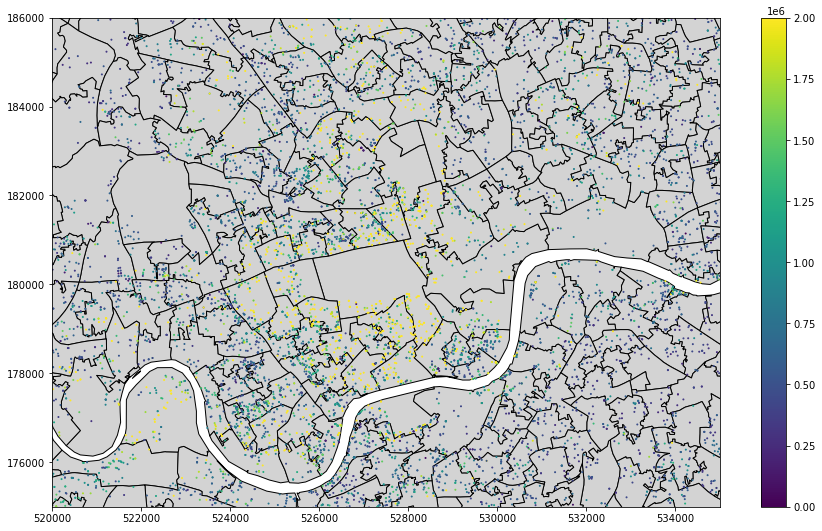

In [248]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15,9))
cmap = plt.cm.viridis
ldn_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black')
gdf_price.plot(column='price_last',cmap=cmap,markersize=1,ax=ax,legend=True,vmin=0,vmax=2000000)
ax.set_xlim([520000,535000])
ax.set_ylim([175000,186000])

/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


(175000.0, 186000.0)

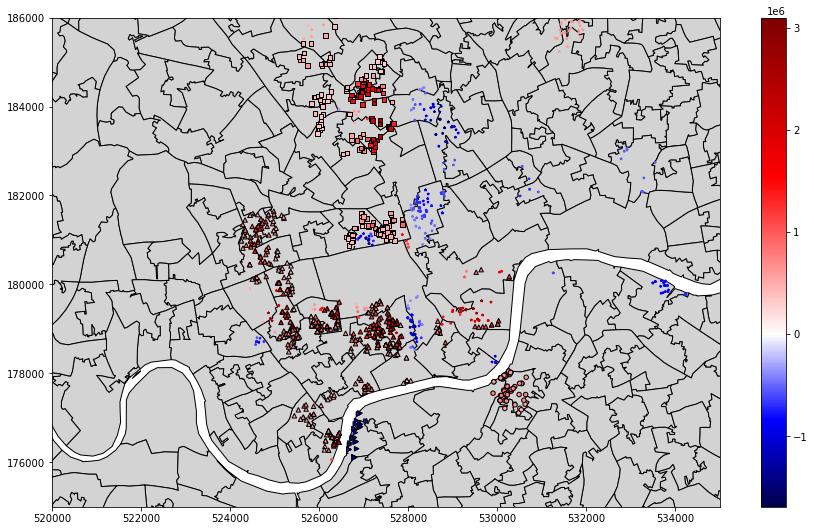

In [210]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15,9))
cmap = plt.cm.seismic

vmin=georgia_data_geo_clu.sentiment_polarity.min()
vmax=georgia_data_geo_clu.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
ldn_msoas.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black')
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
georgia_data_geo_clu.plot( column='sentiment_polarity',marker='*', markersize=5,cmap=cmap,vmin=vmin,vmax=vmax, ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
#         vmin=vmin,vmax=vmax,ax=ax)

georgia_data_geo_clu[georgia_data_geo_clu['clu']==1].plot( column='sentiment_polarity',marker='^',markersize=20,cmap=cmap, edgecolor='black',
         vmin=vmin,vmax=vmax,ax=ax)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==4].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==7].plot( column='sentiment_polarity', markersize=20,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==12].plot( column='sentiment_polarity',marker='>', markersize=20,cmap=cmap, edgecolor='black',
          vmin=vmin,vmax=vmax,ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==1].plot( markersize=1,marker='.',color='black',ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==4].plot( markersize=10,ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==7].plot( markersize=10,ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==6].plot( column='sentiment_polarity',marker='^', markersize=20,cmap=cmap, 
#           vmin=vmin,vmax=vmax,ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==8].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, 
#           vmin=vmin,vmax=vmax,ax=ax)
# georgia_data_geo_clu[georgia_data_geo_clu['clu']==9].plot( column='sentiment_polarity',marker='>', markersize=20,cmap=cmap, 
#           vmin=vmin,vmax=vmax,ax=ax)
cbar = f.colorbar(sm)
ax.set_xlim([520000,535000])
ax.set_ylim([175000,186000])

In [135]:
georgia_data_geo_clu[georgia_data_geo_clu['clu']==6]

,Unnamed: 0,sentiment_polarity,sentiment_subjectivity,geometry,lon,lat,clu
99,99,-813366.832453,1.930777e+05,POINT (529555.175 177574.097),-0.135649,51.482292,6.0
708,708,-783332.982500,4.566771e+04,POINT (529559.989 177548.738),-0.135589,51.482063,6.0
2508,2508,-562591.948283,8.481172e+05,POINT (529758.742 178541.150),-0.132364,51.490936,6.0
3153,3153,-577626.480742,1.371047e+06,POINT (529568.947 178337.240),-0.135171,51.489147,6.0
3587,3587,-500278.599175,5.603035e+05,POINT (529777.029 178624.851),-0.132070,51.491684,6.0
3792,3792,-783332.982500,4.566771e+04,POINT (529559.989 177548.738),-0.135589,51.482063,6.0
5014,5014,-783332.982500,4.566771e+04,POINT (529559.989 177548.738),-0.135589,51.482063,6.0
5360,5360,-783332.982500,4.566771e+04,POINT (529559.989 177548.738),-0.135589,51.482063,6.0
5687,5687,-569555.938456,8.846098e+05,POINT (529687.759 178527.100),-0.133391,51.490826,6.0
7726,7726,-669420.177307,1.039548e+06,POINT (529709.688 178048.507),-0.133251,51.486520,6.0


/opt/conda/envs/sds2021/lib/python3.9/site-packages/mgwr/utils.py:56: UserWarning: Trying to register the cmap 'shiftedcmap' which already exists.
  plt.register_cmap(cmap=new_cmap)


(175000.0, 186000.0)

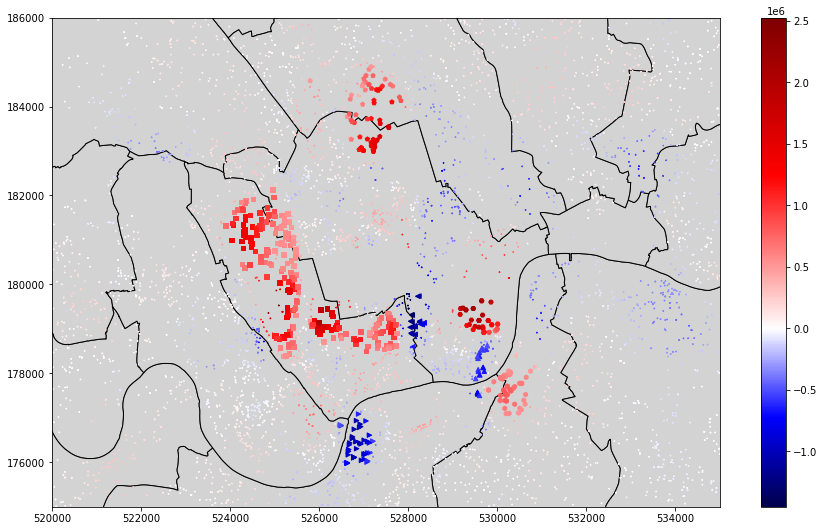

In [149]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15,9))
cmap = plt.cm.seismic

vmin=georgia_data_geo_clu.sentiment_polarity.min()
vmax=georgia_data_geo_clu.sentiment_polarity.max()

# vmin1=ldn_msoas_mean.sentiment_polarity_mean.min()
# vmax1=ldn_msoas_mean.sentiment_polarity_mean.max()
cmap = shift_colormap(cmap,start=0.0, midpoint=1- vmax/(vmax + abs(vmin)))
# vmin=-vmax
sm = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin , vmax = vmax ))
sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = -vmax , vmax = vmax ))
cmap=sm.cmap   
# sm1 = plt.cm.ScalarMappable(cmap=cmap,norm = plt . Normalize (vmin = vmin1 , vmax = vmax1 ))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
borough.plot(facecolor='none',color='lightgrey',ax=ax,edgecolor='black')
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
georgia_data_geo_clu.plot( column='sentiment_polarity',marker='*', markersize=1,cmap=cmap,vmin=vmin,vmax=vmax, ax=ax)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==0].plot( column='sentiment_polarity',marker='s', markersize=20,cmap=cmap, 
        vmin=vmin,vmax=vmax,ax=ax)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==1].plot( column='sentiment_polarity',marker='H', markersize=20,cmap=cmap, 
         vmin=vmin,vmax=vmax,ax=ax)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==2].plot( column='sentiment_polarity',marker='h', markersize=20,cmap=cmap, 
          vmin=vmin,vmax=vmax,ax=ax)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==3].plot( column='sentiment_polarity',marker='p', markersize=20,cmap=cmap, 
          vmin=vmin,vmax=vmax,ax=ax)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==6].plot( column='sentiment_polarity',marker='^', markersize=20,cmap=cmap, 
          vmin=vmin,vmax=vmax,ax=ax)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==8].plot( column='sentiment_polarity',marker='<', markersize=20,cmap=cmap, 
          vmin=vmin,vmax=vmax,ax=ax)
georgia_data_geo_clu[georgia_data_geo_clu['clu']==9].plot( column='sentiment_polarity',marker='>', markersize=20,cmap=cmap, 
          vmin=vmin,vmax=vmax,ax=ax)
cbar = f.colorbar(sm)
ax.set_xlim([520000,535000])
ax.set_ylim([175000,186000])
# ldn_msoas_mean.plot( column='sentiment_polarity_mean' ,cmap=cmap, 
#          legend=True, ax=ax)
# georgia_data_geo.plot( column='sentiment_subjectivity',marker='*', markersize=1,cmap='viridis', 
#          legend=True, ax=ax)
# cq.plot(markersize=100, ax=ax)

# water.plot(edgecolor="none", facecolor='xkcd:lightblue', ax=ax)
# green.plot(edgecolor=(0.7, 0.7, 0.14, 0.25), facecolor=(0.7, 0.7, 0.14), ax=ax)
# gdf.plot(column='price', scheme='Quantiles', k=5, 
#          cmap='viridis', legend=True, marker='*', markersize=0.5, ax=ax)
# boros.plot(edgecolor=(0.8, 0, 0, 0.5), facecolor='none', linewidth=2.5, ax=ax)

In [36]:
citys=['W','WC','E','EC','N','NW','SE','SW','RM','IG','EN','HA','UB','TW','KT','SM','CR','BR','DA']
# citys=['M']
firstflag=0
for city in citys:
    path=r'UBDC/sale_2020/'+city+'/'
    filepath=path+'*complex*.csv'
    #     print(filepath)
    for csvname in glob.glob(filepath):
        print(csvname)
        if firstflag==0:
            df_input=pd.read_csv(csvname[0:-23]+'.csv')[['lon','lat']]
            firstflag=1
        else:
            df_input=df_input.append(pd.read_csv(csvname[0:-23]+'.csv')[['lon','lat']],ignore_index=True)


UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00005clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00002clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00001clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00000clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00006clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00003clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00004clean_token_complex.csv
UBDC/sale_2020/WC/sale_valid_property_id_expanded_year_2020_area_WC_part_00000clean_token_complex.csv
UBDC/sale_2020/E/sale_valid_property_id_expanded_year_2020_area_E_part_00002clean_token_complex.csv
UBDC/sale_2020/E/sale_valid_property_id_expanded_year_2020_area_E_part_00001clean_token_complex.cs

In [31]:
df_input=pd.read_csv(csvname[0:-23]+'.csv')

In [41]:
g=df_input
g=gpd.GeoDataFrame(df_input,geometry=gpd.points_from_xy(df_input.lon, df_input.lat, crs='epsg:4326'))
g=g.to_crs("epsg:27700")
test=gpd.sjoin(g,borough, how="inner", op='intersects').reset_index()

<AxesSubplot:>

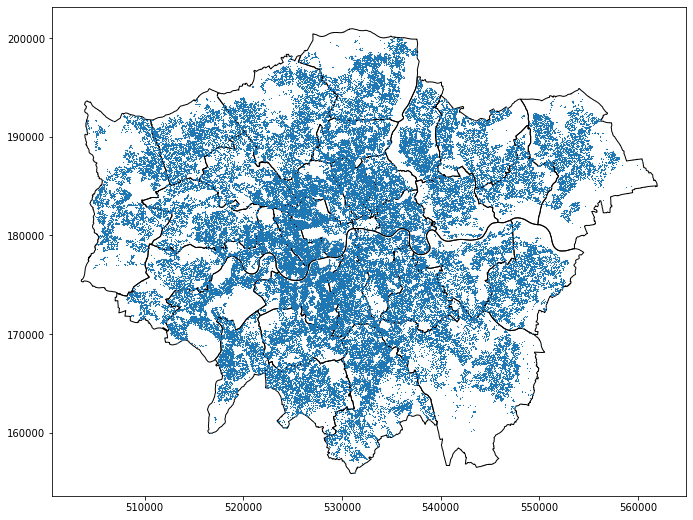

In [7]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(figsize=(15,9))
# gdf[gdf['TCITY15NM']=='London'].plot(facecolor='none',ax=ax)
borough.plot(facecolor='none',ax=ax)
# georgia_shp_geo.plot(column='cof_apartment',cmap='viridis', legend=True, marker='*', markersize=1, ax=ax)
gdf_input.plot( marker='*', markersize=0.01, ax=ax)
# cq.plot(markersize=100, ax=ax)

geo analysis

In [12]:
gdf = gpd.read_file('shapefile/Major_Towns_and_Cities_(December_2015)_Boundaries_V2.geojson')

In [166]:
test_cor1=test_cor[0:6000]
test_y_g1=test_y_g[0:6000]
test_x_g1=test_x_g[0:6000]
scale = gwr_results.scale
residuals = gwr_results.resid_response
model=GWR(train_cor1, train_y_g1, train_x_g1,gwr_bw)
pred_results = model.predict(np.array(test_cor1), test_x_g1, scale, residuals)

In [171]:
np.corrcoef(pred_results.predictions.flatten(), test_y_g1.flatten())[0][1]

0.24423371933838836

In [173]:
from sklearn.metrics import r2_score
r2_score( test_y_g1, pred_results.predictions)

-8.96403363731222

dim reduce

In [5]:
def x_from_df(df:pd.DataFrame, col:str='avg') -> pd.DataFrame:
    cols = ['E'+str(x) for x in np.arange(0,len(df[col].iloc[0]))]
    return pd.DataFrame(df[col].tolist(), columns=cols, index=df.index)

In [6]:
# 伦敦特供
citys=['W','WC','E','EC','N','NW','SE','SW','RM','IG','EN','HA','UB','TW','KT','SM','CR','BR','DA']
# citys=['B']
df_toUMAP=pd.DataFrame( columns=['E'+str(x) for x in np.arange(0,300)])
fileorder=[]
for city in citys:
#     df_toUMAP=pd.DataFrame( columns=['E'+str(x) for x in np.arange(0,300)])
#     fileorder=[]
    path=r'UBDC/sale_2020/'+city+'/'
    filepath=path+'*complex*.csv'
    #     print(filepath)
    for csvname in glob.glob(filepath):
        print(csvname)
        df=pd.read_csv(csvname[0:-23]+'.csv')
        fileorder.append(csvname[0:-23]+'.csv')
        df['avg']=0
        df['avg']=df['avg'].astype('object')
        for count in range(df.shape[0]):
            print(count,end='\r')
            wordlist=eval(df['tfidf_key'].iloc[count])
            lista=np.mean(np.stack( [ngram_model.wv[x] for x in wordlist], axis=0),axis=0).tolist()
            df['avg'].iloc[count]=lista
        df_toUMAP=df_toUMAP.append(x_from_df(df),ignore_index=True)
        
reducer = umap.UMAP(
    n_neighbors=25,
    min_dist=0.01,
    n_components=10,
    random_state=8)

arr_UMAP=reducer.fit_transform(df_toUMAP)
for file in fileorder:
    df=pd.read_csv(file)
    df_UMAP=pd.DataFrame(arr_UMAP[0:df.shape[0]],columns= ['E'+str(x) for x in np.arange(0,10)])
    df=pd.concat([df,df_UMAP],axis=1) 
    df.to_csv(file,encoding="utf_8_sig",index=False)
    arr_UMAP= arr_UMAP[df.shape[0]:]

           

UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00005clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00002clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00001clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00000clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00006clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00003clean_token_complex.csv
UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00004clean_token_complex.csv
UBDC/sale_2020/WC/sale_valid_property_id_expanded_year_2020_area_WC_part_00000clean_token_complex.csv
UBDC/sale_2020/E/sale_valid_property_id_expanded_year_2020_area_E_part_00002clean_token_complex.csv
UBDC/sale_2020/E/sale_valid_property_id_expanded_year_2020_area_E_part_00001clean_token_complex.cs

In [22]:
# citys=['W','WC','E','EC','N','NW','SE','SW']
# citys=['B']
# citys=['BS','CA','M','S','SO']
citys=['G','L']
for city in citys:
    df_toUMAP=pd.DataFrame( columns=['E'+str(x) for x in np.arange(0,300)])
    fileorder=[]
    path=r'UBDC/sale_2020/'+city+'/'
    filepath=path+'*complex*.csv'
    #     print(filepath)
    for csvname in glob.glob(filepath):
        print(csvname)
        df=pd.read_csv(csvname[0:-23]+'.csv')
        fileorder.append(csvname[0:-23]+'.csv')
        df['avg']=0
        df['avg']=df['avg'].astype('object')
        for count in range(df.shape[0]):
            print(count,end='\r')
            wordlist=eval(df['tfidf_key'].iloc[count])
            lista=np.mean(np.stack( [ngram_model.wv[x] for x in wordlist], axis=0),axis=0).tolist()
            df['avg'].iloc[count]=lista
        df_toUMAP=df_toUMAP.append(x_from_df(df),ignore_index=True)
        
    reducer = umap.UMAP(
        n_neighbors=25,
        min_dist=0.01,
        n_components=10,
        random_state=8)

    arr_UMAP=reducer.fit_transform(df_toUMAP)
    for file in fileorder:
        df=pd.read_csv(file)
        df_UMAP=pd.DataFrame(arr_UMAP[0:df.shape[0]],columns= ['E'+str(x) for x in np.arange(0,10)])
        df=pd.concat([df,df_UMAP],axis=1)
        df.to_csv(file,encoding="utf_8_sig",index=False)
        arr_UMAP= arr_UMAP[df.shape[0]:]

UBDC/sale_2020/G/sale_valid_property_id_expanded_year_2020_area_G_part_00002clean_token_complex.csv
UBDC/sale_2020/G/sale_valid_property_id_expanded_year_2020_area_G_part_00003clean_token_complex.csv
UBDC/sale_2020/G/sale_valid_property_id_expanded_year_2020_area_G_part_00000clean_token_complex.csv
UBDC/sale_2020/G/sale_valid_property_id_expanded_year_2020_area_G_part_00001clean_token_complex.csv
UBDC/sale_2020/L/sale_valid_property_id_expanded_year_2020_area_L_part_00003clean_token_complex.csv


/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


UBDC/sale_2020/L/sale_valid_property_id_expanded_year_2020_area_L_part_00002clean_token_complex.csv
UBDC/sale_2020/L/sale_valid_property_id_expanded_year_2020_area_L_part_00001clean_token_complex.csv
UBDC/sale_2020/L/sale_valid_property_id_expanded_year_2020_area_L_part_00000clean_token_complex.csv
UBDC/sale_2020/L/sale_valid_property_id_expanded_year_2020_area_L_part_00004clean_token_complex.csv


In [ ]:
vectorizer = CountVectorizer()  
X = vectorizer.fit_transform(str(x) for x in df_input['tfidf_key'])
word=vectorizer.get_feature_names()
tfidfX=X.toarray()
tfsum=[]
for x in range(tfidfX.shape[1]):
    tfsum.append(tfidfX[:,x].sum())
aa=pd.DataFrame(tfsum,index=word)
aa.to_csv('关键词数量.csv')

In [12]:
df_input

,end_date,price_last,num_bed_last,bed_flag,num_floors_max,num_bath_max,num_reception_max,apartment,road,locate,...,E2,E3,E4,E5,E6,E7,E8,E9,lon,lat
0,470,535000,2,1,0,1,1,1,0,1,...,6.332038,4.765020,4.573756,3.682383,5.185334,5.111811,6.612181,0.782712,-0.211246,51.532047
1,342,1775000,4,1,0,2,3,0,0,0,...,7.168433,4.858564,5.100959,4.429404,6.235758,4.187451,7.770622,2.798664,-0.235905,51.507300
2,534,2750000,3,1,2,2,2,0,0,0,...,5.520174,4.301838,5.149521,4.295793,6.323512,4.972039,6.969428,2.997444,-0.210000,51.508656
3,427,925000,3,1,0,2,1,0,1,0,...,4.701004,2.640843,10.141196,5.547108,10.451303,4.125553,8.523055,2.955322,-0.206540,51.485943
4,310,900000,3,1,0,1,1,1,0,1,...,6.581747,4.219230,4.387836,3.622073,6.211455,4.097757,7.596332,2.007897,-0.188811,51.526962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536163,377,330000,3,1,0,1,2,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.356468,51.439644
536164,374,550000,4,1,0,2,2,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.119225,51.430298
536165,547,265000,2,1,0,0,0,0,0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.217779,51.449123
536166,181,775000,4,1,0,1,3,0,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105939,51.423560


In [17]:
# pip install stylecloud
import stylecloud

In [26]:
# citys=['W','WC','E','EC','N','NW','SE','SW']
# for city in citys:
#     path=r'UBDC/sale_2020/'+city+'/'
#     filepath=path+'*complex*.csv'
#     #     print(filepath)
#     for csvname in glob.glob(filepath):
#         print(csvname)        
df=pd.read_csv('UBDC/sale_2020/W/sale_valid_property_id_expanded_year_2020_area_W_part_00005.csv')
df.iloc[:,0:-22]

,Unnamed: 0,Unnamed: 0.1,listing_id,property_type,start_date,end_date,price_first,price_last,price_min,price_max,...,agent_phone,agent_address,agent_postcode,image_caption,thumbnail_url,floor_plan,original_image,bullet,lad20nm,tfidf_key
0,0,0,43853510,Flat,2021-01-13,2021-03-31,550000,500000,500000,550000,...,020 8166 3362,"1 Baker Street, London",W1U 8ED,Picture No.11,https://lid.zoocdn.com/80/60/5b4f308291338a035...,"[""https://lc.zoocdn.com/de223e3ddd30941d7f2799...","[""https://lc.zoocdn.com/5b4f308291338a0357f166...",[],Westminster,"['green', 'conveniently', 'archway', 'modern',..."
1,1,1,54843724,NaN,2020-05-02,2020-07-06,2500000,2500000,2500000,2500000,...,020 8995 4321,"388 Chiswick High Road, Chiswick, London",W4 5TF,NaN,https://lid.zoocdn.com/80/60/96e84fabb712b4522...,"[""https://lc.zoocdn.com/2057e60b7e01649b35eb20...","[""https://lc.zoocdn.com/96e84fabb712b4522ea651...","[""Victorian Home"", ""Five Bedrooms"", ""Two Bathr...",Ealing,"['station', 'feature', 'amenity', 'terrace', '..."
2,2,2,45796302,Semi-detached house,2020-08-11,2021-01-11,950000,950000,950000,950000,...,020 3551 4501,"53 Old Oak Common Lane, Acton",W3 7DD,NaN,https://lid.zoocdn.com/80/60/6dabfb2962a5cf3c6...,"[""https://lc.zoocdn.com/755046106520b848633cd3...","[""https://lc.zoocdn.com/6dabfb2962a5cf3c684736...","[""Three Bedroom Semi-Detached House"", ""Two Rec...",Ealing,"['reception', 'viewing', 'heating', 'locate', ..."
3,3,3,54411227,Flat,2020-02-29,2020-04-20,320000,324950,320000,324950,...,020 3478 3621,"5 Station Parade, Uxbridge Road, Ealing, London",W5 3LD,Photo,https://lid.zoocdn.com/80/60/a6ce4157e37841258...,"[""https://lc.zoocdn.com/528b2ca72e4c66b78406df...","[""https://lc.zoocdn.com/a6ce4157e37841258f0509...","[""A designer superbly-appointed 1-bedroom new ...",Ealing,"['surveyor_references', 'abbey', 'rent_annum',..."
4,4,4,56509130,Flat,2020-10-08,2020-12-04,1200000,1200000,1200000,1200000,...,020 8022 5507,"298 Westbourne Grove, London",W11 2PS,Image,https://lid.zoocdn.com/80/60/4faeafb279c75bdc1...,"[""https://lc.zoocdn.com/485b9fa04760fe3ab18a8f...","[""https://lc.zoocdn.com/4faeafb279c75bdc14d907...","[""2 bedrooms"", ""1 reception room"", ""1 bathroom...",Westminster,"['cafe', 'famous', 'outlook', 'coffee', 'abund..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6939,6939,6939,55960118,Detached house,2021-01-05,2021-03-31,2150000,2150000,2150000,2150000,...,020 8022 4555,"78 Westbourne Grove, Bayswater, London",W2 5RT,Picture No. 08,https://lid.zoocdn.com/80/60/f45a6ac1665a1bc15...,"[""https://lc.zoocdn.com/105f8598100b9d944f972f...","[""https://lc.zoocdn.com/f45a6ac1665a1bc15c0360...","[""Ground floor reception room"", ""First floor r...",Kensington and Chelsea,"['storey', 'en', 'planning_permission', 'solid..."
6940,6940,6940,58068342,Flat,2021-03-24,2021-03-31,649950,649950,649950,649950,...,020 8810 0909,"2 New Ealing Broadway, London",W5 2NU,NaN,https://lid.zoocdn.com/80/60/5b111b939a0b9aeb5...,"[""https://lc.zoocdn.com/40dac4058ab55e704331d1...","[""https://lc.zoocdn.com/5b111b939a0b9aeb54df02...","[""Three Bedrooms"", ""Two Bathrooms"", ""Private B...",Ealing,"['school', 'walk', 'garage', 'private', 'apart..."
6941,6941,6941,54079702,Flat,2020-01-29,2020-02-12,380000,380000,380000,380000,...,020 8022 4160,"33 Margaret Street, London",W1G 0JD,NaN,https://lid.zoocdn.com/80/60/3d39620a2b91a91cb...,NaN,"[""https://lc.zoocdn.com/3d39620a2b91a91cb9a8f7...",[],Westminster,"['carry', 'auction', 'canal', 'vacant', 'apart..."
6942,6942,6942,56835879,Flat,2020-11-05,2021-02-04,730000,730000,730000,730000,...,020 8022 3247,"166 Shepherd's Bush Road, London",W6 7PB,Reception,https://lid.zoocdn.com/80/60/36fd7274c8412aba3...,"[""https://lc.zoocdn.com/b374ca2d9c5334117699b8...","[""https://lc.zoocdn.com/36fd7274c8412aba3e94ad...","[""Virtual Tour upon Request"", ""Garden"", ""0.5 m...",Hammersmith and Fulham,"['mile', 'hub', 'excellently', 'float', 'heath..."


In [22]:
stopWords = [w.strip() for w in codecs.open('stopword2.txt', 'r').readlines()]
citys=['W','WC','E','EC','N','NW','SE','SW','B','L','M','G','BS','S','RM','IG','EN','HA','UB','TW','KT','SM','CR','BR','DA']
# citys=['B']
# second stop word remove from sim.csv
for city in citys:
    path=r'UBDC/sale_2020/'+city+'/'
    filepath=path+'*sim*.csv'
    #     print(filepath)
    firstflag=0
    for csvname in glob.glob(filepath):
        print(csvname)
        df_sim=pd.read_csv(csvname)
        df_sim['0']=df_sim['0'].apply(ast.literal_eval)
        for count in range(df_sim.shape[0]):
            delwords=[]
            list_word=df_sim['0'].iloc[count]
            for count1 in range(len(df_sim['0'].iloc[count])):
                word=list_word[count1]
                if word in stopWords :
                    delwords.append(word)
            for  x in delwords:
                list_word.remove(x)
            df_sim['0'].iloc[count]=list_word
        df_sim.to_csv(csvname,index=False)
# #去 E1什么的       
# citys=['W','WC','E','EC','N','NW','SE','SW']        
# for city in citys:
#     path=r'UBDC/sale_2020/'+city+'/'
#     filepath=path+'*complex*.csv'
#     #     print(filepath)
#     for csvname in glob.glob(filepath):
#         print(csvname)        
#         df=pd.read_csv(csvname[0:-23]+'.csv')
#         df=df.iloc[:,0:-22]
#         df.to_csv(csvname[0:-23]+'.csv',index=False,encoding="utf_8_sig")
        
# citys=['RM','IG','EN','HA','UB','TW','KT','SM','CR','BR','DA']        
# for city in citys:
#     path=r'UBDC/sale_2020/'+city+'/'
#     filepath=path+'*complex*.csv'
#     #     print(filepath)
#     for csvname in glob.glob(filepath):
#         print(csvname)        
#         df=pd.read_csv(csvname[0:-23]+'.csv')
#         df=df.iloc[:,0:-10]
#         df.to_csv(csvname[0:-23]+'.csv',index=False,encoding="utf_8_sig")


# cc=['B','L','M','G','BS','S']
# for city in cc:
#     path=r'UBDC/sale_2020/'+city+'/'
#     filepath=path+'*complex*.csv'
#     #     print(filepath)
#     for csvname in glob.glob(filepath):
#         print(csvname)        
#         df=pd.read_csv(csvname[0:-23] + '.csv')
#         df=df.iloc[:,0:-12]
#         df.to_csv(csvname[0:-23]+ '.csv',index=False,encoding="utf_8_sig")




UBDC/sale_2020/W/00001_token_sim.csv
UBDC/sale_2020/W/00004_token_sim.csv
UBDC/sale_2020/W/00002_token_sim.csv
UBDC/sale_2020/W/00000_token_sim.csv
UBDC/sale_2020/W/00005_token_sim.csv
UBDC/sale_2020/W/00006_token_sim.csv
UBDC/sale_2020/W/00003_token_sim.csv
UBDC/sale_2020/WC/00000_token_sim.csv
UBDC/sale_2020/E/00001_token_sim.csv
UBDC/sale_2020/E/00004_token_sim.csv
UBDC/sale_2020/E/00002_token_sim.csv
UBDC/sale_2020/E/00000_token_sim.csv
UBDC/sale_2020/E/00005_token_sim.csv
UBDC/sale_2020/E/00006_token_sim.csv
UBDC/sale_2020/E/00003_token_sim.csv
UBDC/sale_2020/EC/00000_token_sim.csv
UBDC/sale_2020/N/00001_token_sim.csv
UBDC/sale_2020/N/00004_token_sim.csv
UBDC/sale_2020/N/00002_token_sim.csv
UBDC/sale_2020/N/00000_token_sim.csv
UBDC/sale_2020/N/00005_token_sim.csv
UBDC/sale_2020/N/00003_token_sim.csv
UBDC/sale_2020/NW/00001_token_sim.csv
UBDC/sale_2020/NW/00004_token_sim.csv
UBDC/sale_2020/NW/00002_token_sim.csv
UBDC/sale_2020/NW/00000_token_sim.csv
UBDC/sale_2020/NW/00003_token_si

In [21]:
import wordcloud
wc = wordcloud.WordCloud( width = 1000,
                         height = 700,
                         background_color='white',
                         max_words=300,collocations=False)

wc.generate(text) # 加载词云文本
wc.to_file("wcold2.png") # 保存词云文件

In [21]:
 df_sim['0']

0       [split, level, floor, apartment, conversion, f...
1       [light, fill, bedroom, top, floor, apartment, ...
2       [lovingly, creatively, design, apartment, disp...
3       [virtual_tour, impose, semi, detached, victori...
4       [bedroom, victorian, family, square, bay, attr...
                              ...                        
6917    [locationlocated, heart, white, city, bbc, tv,...
6918    [modern, top, floor, double, bedroom, purpose,...
6919    [considered, london, mansion, exceptional, may...
6920    [extended, tastefully, refurbish, bedroom, hou...
6921    [park, estates, pleased, offer, sale, charming...
Name: 0, Length: 6922, dtype: object

In [18]:
# 伯明翰新词云       
filepath=r'UBDC/sale_2020/B/*sim*.csv'
firstflag=0
for csvname in glob.glob(filepath):
    print(csvname)        
    if firstflag==0:
        df_input=pd.read_csv(csvname)['0']
        firstflag=1
    else:
        df_input=df_input.append(pd.read_csv(csvname)['0'],ignore_index=True)
fh = open('666.txt', 'w', encoding='utf-8')
text=''
for count in range(df_input.shape[0]):
    print(count,end='\r')
    for w1 in eval(df_input[count]):
        text=text+' '+w1
    fh.write(text)
    text=' '
fh.close()

UBDC/sale_2020/B/00001_token_sim.csv
UBDC/sale_2020/B/00004_token_sim.csv
UBDC/sale_2020/B/00008_token_sim.csv
UBDC/sale_2020/B/00010_token_sim.csv
UBDC/sale_2020/B/00009_token_sim.csv
UBDC/sale_2020/B/00002_token_sim.csv
UBDC/sale_2020/B/00000_token_sim.csv
UBDC/sale_2020/B/00005_token_sim.csv
UBDC/sale_2020/B/00006_token_sim.csv
UBDC/sale_2020/B/00007_token_sim.csv
UBDC/sale_2020/B/00003_token_sim.csv


In [20]:
f = open("666.txt",encoding = "utf-8")

text=f.read()

In [13]:
len(text)

113365709

In [12]:
# 伯明翰旧词云       
filepath=r'UBDC/sale_2020/B/*complex*.csv'
firstflag=0
for csvname in glob.glob(filepath):
    print(csvname)        
    if firstflag==0:
        df_input=pd.read_csv(csvname[0:-23]+'.csv')['tfidf_key']
        firstflag=1
    else:
        df_input=df_input.append(pd.read_csv(csvname[0:-23]+'.csv')['tfidf_key'],ignore_index=True)
text=''
for count in range(df_input.shape[0]):
    print(count,end='\r')
    for w1 in eval(df_input[count]):
        text=text+' '+w1
            


UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00009clean_token_complex.csv
UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00006clean_token_complex.csv
UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00000clean_token_complex.csv
UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00003clean_token_complex.csv
UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00002clean_token_complex.csv
UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00010clean_token_complex.csv
UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00005clean_token_complex.csv
UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00007clean_token_complex.csv
UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00008clean_token_complex.csv
UBDC/sale_2020/B/sale_valid_property_id_expanded_year_2020_area_B_part_00004clean_token_complex.csv


NameError: name 'wordcloud' is not defined